In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

In [2]:
import pandas as pd

df = pd.read_csv("hour.csv")

print(df.shape)
print(df.columns)
print(df.head())


(17379, 17)
Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')
   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.2

In [3]:
# df['hour_mean'] = df.groupby('hr')['cnt'].transform('mean')
# print(df[['dteday', 'hr', 'cnt', 'hour_mean']].head(10))

In [4]:
from dataclasses import dataclass

@dataclass(frozen=True)
class PlotColors:
    true: str = "black"
    lds: str = "tab:blue"
    ar2: str = "tab:orange"
    arma21: str = "tab:green"

In [5]:
def plot1(lags, data, title, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # ACF
    plot_acf(
        data,
        lags=lags,
        ax=axes[0],
        alpha=0.05,      # confidence band alpha
        marker='o',
        markersize=3
    )
    axes[0].set_title(f"ACF {title}")
    axes[0].set_xlabel("Lag (hours)")
    axes[0].set_ylabel("Autocorrelation")

    # PACF
    plot_pacf(
        data,
        lags=lags,
        method='ywm',
        ax=axes[1],
        alpha=0.05,
        marker='o',
        markersize=3
    )
    axes[1].set_title(f"PACF {title}")
    axes[1].set_xlabel("Lag (hours)")
    axes[1].set_ylabel("Partial Autocorrelation")

    # Make points smaller + lighter
    for ax in axes:
        for line in ax.lines:
            line.set_markersize(3)   # smaller dots
            line.set_alpha(0.5)      # more transparent

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()

# plot1(200, train['cnt'], "train bike count", "test.jpg")

## Dataset split

In [6]:
split_index = int(len(df) * 0.8)

train = df.iloc[:split_index].copy()
test = df.iloc[split_index:].copy()

print("Train size:", len(train))
print("Test size:", len(test))
train.head(), test.head()

Train size: 13903
Test size: 3476


(   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
 0        1  2011-01-01       1   0     1   0        0        6           0   
 1        2  2011-01-01       1   0     1   1        0        6           0   
 2        3  2011-01-01       1   0     1   2        0        6           0   
 3        4  2011-01-01       1   0     1   3        0        6           0   
 4        5  2011-01-01       1   0     1   4        0        6           0   
 
    weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
 0           1  0.24  0.2879  0.81        0.0       3          13   16  
 1           1  0.22  0.2727  0.80        0.0       8          32   40  
 2           1  0.22  0.2727  0.80        0.0       5          27   32  
 3           1  0.24  0.2879  0.75        0.0       3          10   13  
 4           1  0.24  0.2879  0.75        0.0       0           1    1  ,
        instant      dteday  season  yr  mnth  hr  holiday  weekday  \
 13903    1390

massive spikes at lag 24, 48, 72, 96…

high amplitude, regular, sharp

periodic pattern dominated by the mean cycle

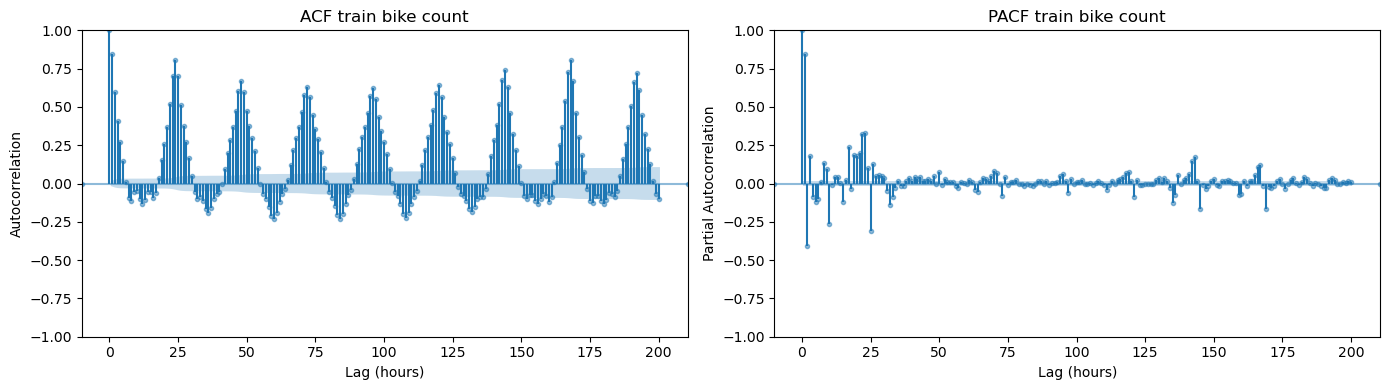

In [7]:
plot1(200, train['cnt'], "train bike count")

## Seasonality Removal 

The raw hourly bike demand shows strong daily seasonality, with consistent morning/evening peaks and nighttime lows.  
To remove this deterministic pattern, we subtract the long-run average demand for each hour of the day:

$$
r_t = x_t - \mu_{hr(t)}
$$

where

$$
\mu_h = \mathbb{E}[x_t \mid hr(t) = h].
$$

This deseasonalization removes the dominant hour-of-day effect while preserving meaningful short-term fluctuations.  
The resulting residual series is centered around zero and suitable for ARMA, LDS, and HMM modeling.

**Note: we will use only training set to compute the mean, and compute residual of test set with this train mean**

In [8]:
# 1. Compute hour-of-day mean on TRAIN only
hour_mean_train = train.groupby('hr')['cnt'].mean()

# 2. Assign train hour_mean
train['hour_mean'] = train['hr'].map(hour_mean_train)

# 3. Compute train residuals
train['residual'] = train['cnt'] - train['hour_mean']

# 4. Apply the SAME hour_mean mapping to TEST
# If an hour appears in test but not in train (unlikely), fill with global train mean
test['hour_mean'] = test['hr'].map(hour_mean_train)
test['hour_mean'] = test['hour_mean'].fillna(hour_mean_train.mean())

# 5. Compute test residuals
test['residual'] = test['cnt'] - test['hour_mean']

In [9]:
from statsmodels.tsa.stattools import adfuller

# check for training set
res = adfuller(train['residual'].dropna())

print("ADF Statistic:", res[0])
print("p-value:", res[1])
print("Used lags:", res[2])
print("Number of observations:", res[3])
print("Critical Values:", res[4])

ADF Statistic: -5.850056179878249
p-value: 3.606948587941335e-07
Used lags: 42
Number of observations: 13860
Critical Values: {'1%': -3.4308218983783987, '5%': -2.8617485574092236, '10%': -2.5668810102936184}


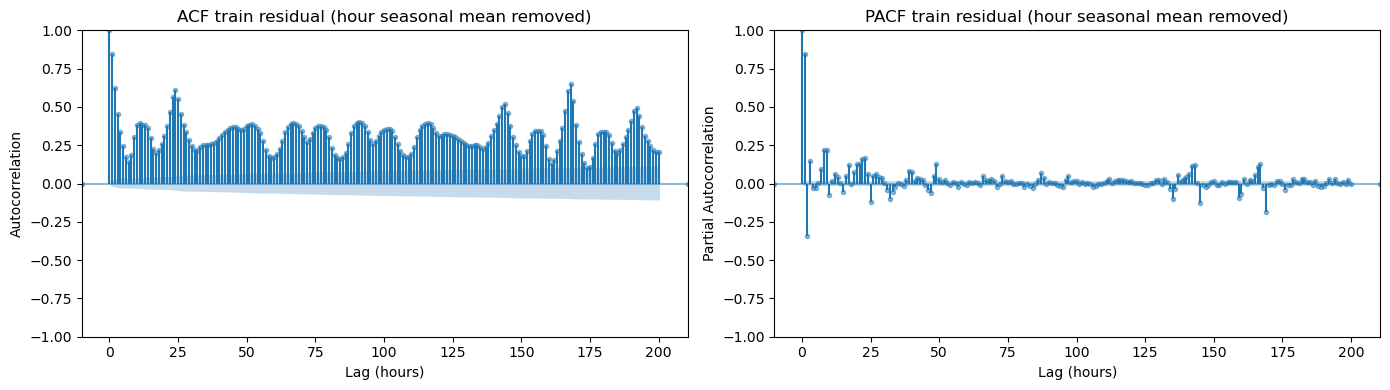

In [10]:
plot1(200, train['residual'], "train residual (hour seasonal mean removed)")

## weekday x hour of day Removal

In [11]:
# hour x day of week seasonality remove
seasonal_means = (
    train.groupby(['weekday', 'hr'])['cnt']
      .mean()
      .unstack()
)
train['seasonal_mean'] = train.apply(
    lambda row: seasonal_means.loc[row['weekday'], row['hr']],
    axis=1
)
train['residual1'] = train['cnt'] - train['seasonal_mean']

# Seasonal mean for TEST set (weekday × hour)
test['seasonal_mean'] = test.apply(
    lambda row: seasonal_means.loc[row['weekday'], row['hr']],
    axis=1
)
test['residual1'] = test['cnt'] - test['seasonal_mean']

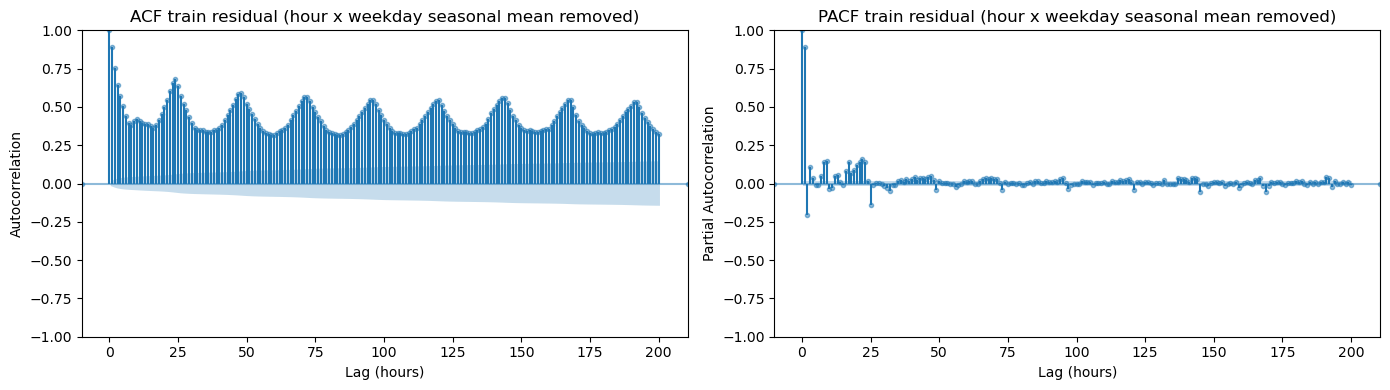

In [12]:
plot1(200, train['residual1'], "train residual (hour x weekday seasonal mean removed)")

In [13]:
res1 = adfuller(train['residual1'].dropna())

print("ADF Statistic:", res1[0])
print("p-value:", res1[1])
print("Used lags:", res1[2])
print("Number of observations:", res1[3])
print("Critical Values:", res1[4])

ADF Statistic: -5.865935297264503
p-value: 3.3256087089139496e-07
Used lags: 42
Number of observations: 13860
Critical Values: {'1%': -3.4308218983783987, '5%': -2.8617485574092236, '10%': -2.5668810102936184}


Analysis: 
- remove weekday based on hour of day offers a slightly more negative ADF stat than hour of day only (-5.866 < -5.850). 
- by plots, ACF in (hour x weekday) shows smoother decay, and the pattern seen in (hour only) is reduced. This **less deterministic structure** may help ARMA to learn better. Also, we can see ACF in (hour x weekday) has a more visible spike at lag 48 (2days), that is because this removal clean up the combination of weekday x hour impact. So when we plot lags of 200 (over 8 days), we can see pattern of autocorrelation are more consistent, less noisy. That is exactly the result we want to achieve by removing seasonality (clean up noise).
- by plots, PACF in (hour x weekday) share similar pattern but overall magnitudes is slightly smaller, indicating fewer secondary correlations in this case.

> **We continue with hour x workday removal.**

-------

## ARMA

### Determining ARMA(p, q) Orders from ACF and PACF

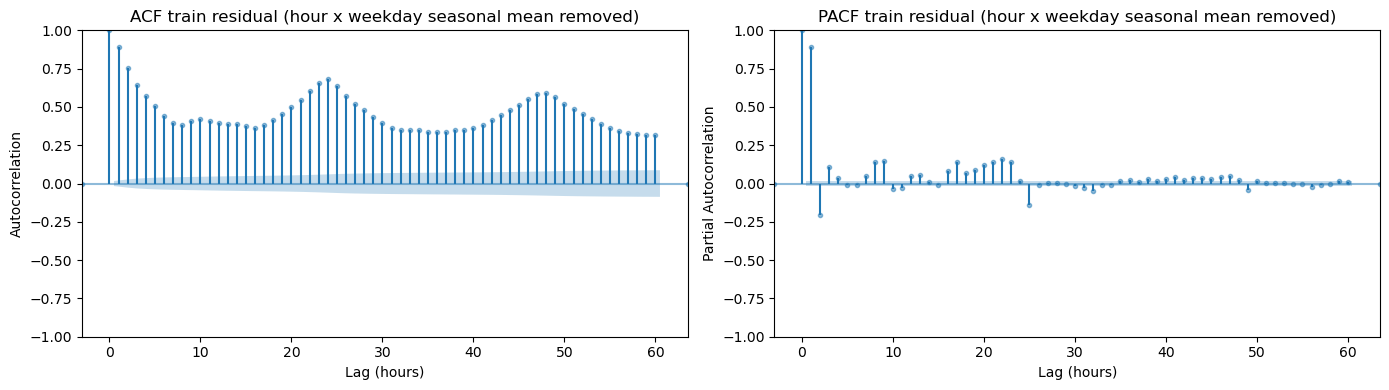

In [14]:
plot1(60, train['residual1'], "train residual (hour x weekday seasonal mean removed)")

#### 1. PACF Analysis → Determines AR Order `p`
The PACF of the residual series shows:

- A **very strong spike at lag 1**
- Another **significant spike at lag 2**
- All remaining spikes are small and within the confidence band

**Interpretation:**

A sharp cutoff in PACF after lag `p` indicates an AR(p) model.

Since the PACF has large values at lags 1 and 2 and then drops off,
this strongly suggests: **AR(2)** structure

#### 2. ACF Analysis → Determines MA Order `q`

The ACF of the residual series:

- Decays slowly and smoothly
- Exhibits an oscillatory pattern
- Does **not** show a sharp cutoff at any specific lag

**Interpretation:**

A slow decay in the ACF indicates AR behavior, while a sharp cutoff would
suggest MA(q). Because no cutoff is observed, the ACF does **not** strongly support
a pure MA model. However, the slow decay suggests that including a small MA term
may improve the fit. But your PACF also shows a significant spike at lag 1 and some weak remaining structure.
This indicates short-memory shock noise that is not fully explained by the AR terms. These disturbances correspond to random components not captured by deterministic seasonality or AR structure.

shock: A sudden, unexpected change that is not explained by the usual pattern.

attempts: **ARMA(2, 0)**, **ARMA(2, 1)**

### ARMA fit

In [15]:
# Fit AR(2) model (ARIMA with q=0, d=0)
model_ar2 = ARIMA(train['residual1'], order=(2, 0, 0)).fit()

print(model_ar2.summary())
print("AIC:", model_ar2.aic)

                               SARIMAX Results                                
Dep. Variable:              residual1   No. Observations:                13903
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -72698.702
Date:                Tue, 13 Jan 2026   AIC                         145405.405
Time:                        16:06:32   BIC                         145435.564
Sample:                             0   HQIC                        145415.449
                              - 13903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.774e-07      2.946  -6.02e-08      1.000      -5.773       5.773
ar.L1          1.0707      0.005    202.438      0.000       1.060       1.081
ar.L2         -0.2024      0.006    -31.573      0.0

In [16]:
# Fit ARMA(2,1)
model_arma21 = ARIMA(train['residual1'], order=(2, 0, 1)).fit()

print(model_arma21.summary())
print("AIC:", model_arma21.aic)

                               SARIMAX Results                                
Dep. Variable:              residual1   No. Observations:                13903
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -72642.284
Date:                Tue, 13 Jan 2026   AIC                         145294.568
Time:                        16:06:33   BIC                         145332.268
Sample:                             0   HQIC                        145307.123
                              - 13903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.815e-05      3.088  -2.53e-05      1.000      -6.052       6.052
ar.L1          0.7644      0.031     24.299      0.000       0.703       0.826
ar.L2          0.0689      0.030      2.305      0.0

In [17]:
print("AIC AR(2):", model_ar2.aic)
print("AIC ARMA(2,1):", model_arma21.aic)

AIC AR(2): 145405.4049430189
AIC ARMA(2,1): 145294.5684137105


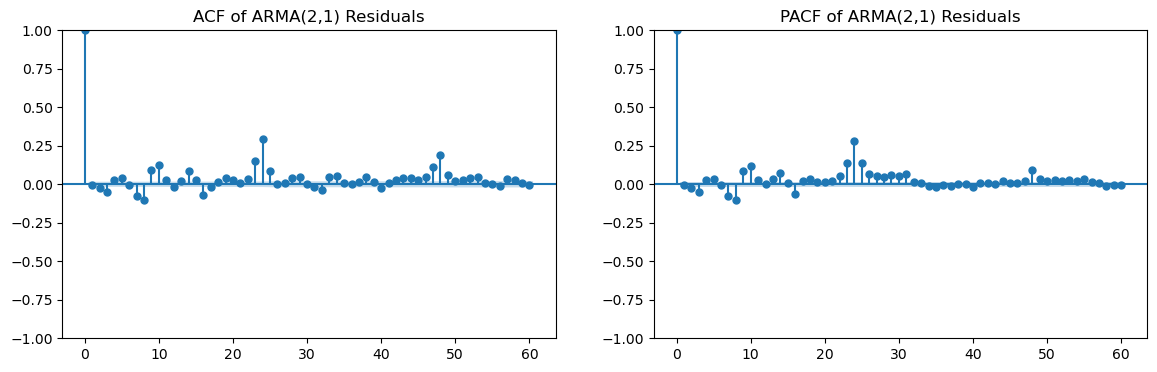

In [18]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
plot_acf(model_arma21.resid, lags=60, ax=ax[0])
plot_pacf(model_arma21.resid, lags=60, ax=ax[1])
ax[0].set_title("ACF of ARMA(2,1) Residuals")
ax[1].set_title("PACF of ARMA(2,1) Residuals")
plt.show()

A lower AIC indicates a better balance between model fit and complexity.
Since **ARMA(2,1) achieves a substantially lower AIC** than AR(2), it is the preferred model statistically.

> **Conclusion:**  
> **ARMA(2,1)** provides a significantly better fit than AR(2).

The ACF and PACF plots of the ARMA(2,1) residuals show:

- All autocorrelation values lie very close to zero.
- No significant spikes remain outside the confidence intervals.
- There is no systematic pattern or remaining cyclical structure.
- PACF similarly shows no meaningful remaining partial correlations.

This indicates that:

1. The ARMA(2,1) model has successfully captured the serial dependence in the data.
2. The residuals behave like white noise—an essential requirement for a well-specified ARMA model.

> **Conclusion:**  
> The residual diagnostics confirm that **ARMA(2,1)** adequately models the stochastic structure of the deseasonalized series. No further AR or MA terms appear necessary.

---

Quick comparison with residual (hour removal only)

In [19]:
# Fit ARMA(2,1) using time only removal for comparison
model_ar2_res_hour = ARIMA(train['residual'], order=(2, 0, 0)).fit()
model_arma21_res_hour = ARIMA(train['residual'], order=(2, 0, 1)).fit()
print("model_ar2_res_hour AIC:", model_ar2_res_hour.aic)
print("model_arma21_res_hour AIC:", model_arma21_res_hour.aic)

model_ar2_res_hour AIC: 152722.54762628596
model_arma21_res_hour AIC: 152437.9003493922


AIC Comparison: Hour-Only vs Hour×Weekday Seasonality Removal

| Model Type | Residual Version | AIC |
|------------|------------------|---------------------|
| AR(2)      | Hour-only        | 152,722.55 |
| ARMA(2,1)  | Hour-only        | 152,437.90 |
| AR(2)      | Hour × Weekday   | 145,405.40 |
| ARMA(2,1)  | Hour × Weekday   | 145,294.57 |

Observations
- Using the **hour × weekday residuals** lowers the AIC by **~7,300** compared to the hour-only method.
- The ARMA(2,1) model consistently achieves lower AIC than AR(2) for both residual types.
- The **best model overall** is **ARMA(2,1) using hour × weekday seasonal removal**, with the lowest AIC (145,294.57).

In [20]:
model_arma21.params

const       -0.000078
ar.L1        0.764368
ar.L2        0.068930
ma.L1        0.328280
sigma2    2022.080668
dtype: float64

### ARMA Prediction

In [21]:
def rolling_arma21(train, test, const, phi1, phi2, theta1):
    """
    True rolling 1-step-ahead ARMA(2,1) forecasting.
    No refitting. Extremely fast.
    """
    y = list(train.values)
    preds = []
    # initialize errors (set last error to 0)
    last_err = 0  

    # initial in-sample forecast for y[-1] to get last_err
    y_hat_prev = const + phi1*y[-1] + phi2*y[-2]
    last_err = y[-1] - y_hat_prev

    for t in range(len(test)):
        y_tm1 = y[-1]
        y_tm2 = y[-2]

        # 1-step forecast
        y_hat = const + phi1*y_tm1 + phi2*y_tm2 + theta1*last_err
        
        preds.append(y_hat)

        # update error using the TRUE future value
        true_y = test.iloc[t]
        last_err = true_y - y_hat

        # update the series
        y.append(true_y)

    return np.array(preds)

# --- Rolling forecasts for residual1 ---
resid_train = train['residual1']
resid_test  = test['residual1']

pred_resid_arma21_roll = rolling_arma21(
    train = resid_train,
    test = resid_test,
    const = model_arma21.params['const'],
    phi1 = model_arma21.params['ar.L1'],
    phi2 = model_arma21.params['ar.L2'],
    theta1 = model_arma21.params['ma.L1']
)

pred_resid_ar2_roll = rolling_arma21(
    train = resid_train,
    test = resid_test,
    const = model_ar2.params['const'],
    phi1 = model_ar2.params['ar.L1'],
    phi2 = model_ar2.params['ar.L2'],
    theta1 = 0 # MA(0) in this case
)

After fitting the ARMA(2,1) model on the training residuals, we obtain the
parameters:

- `const` = $c$
- `ar.L1` = $\phi_1$
- `ar.L2` = $\phi_2$
- `ma.L1` = $\theta_1$

The ARMA(2,1) model is:

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \epsilon_t + \theta_1 \epsilon_{t-1},
$$

where $\epsilon_t$ is white noise.

For one-step-ahead prediction, the noise has mean zero, so the conditional mean
is:

$$
\hat{y}_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \theta_1 \epsilon_{t-1},
$$

with

$$
\epsilon_{t-1} = y_{t-1} - \hat{y}_{t-1}.
$$

Then we do this simple recursive forecasting procedure.

In [22]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

### Analysis on predicted residual

In [23]:
# Evaluate on residual1
mae_ar2_r,  rmse_ar2_r  = evaluate(resid_test, pred_resid_ar2_roll)
mae_a21_r,  rmse_a21_r  = evaluate(resid_test, pred_resid_arma21_roll)

print("ROLLING AR(2) residual1     - MAE:", mae_ar2_r,  "RMSE:", rmse_ar2_r)
print("ROLLING ARMA(2,1) residual1 - MAE:", mae_a21_r, "RMSE:", rmse_a21_r)

ROLLING AR(2) residual1     - MAE: 42.053318014404084 RMSE: 65.4162113953737
ROLLING ARMA(2,1) residual1 - MAE: 41.882434988136346 RMSE: 64.95978205131472


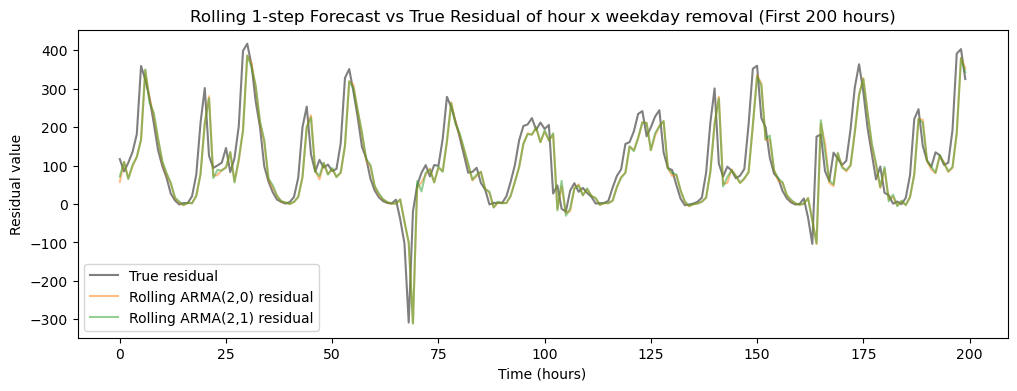

In [24]:
plt.figure(figsize=(12,4))
plt.plot(resid_test.values[:200], label='True residual', alpha=0.5, color = PlotColors.true)
plt.plot(pred_resid_ar2_roll[:200], label='Rolling ARMA(2,0) residual', alpha=0.5, color = PlotColors.ar2)
plt.plot(pred_resid_arma21_roll[:200], label='Rolling ARMA(2,1) residual', alpha=0.5, color = PlotColors.arma21)
plt.title("Rolling 1-step Forecast vs True Residual of hour x weekday removal (First 200 hours)")
plt.xlabel("Time (hours)")
plt.ylabel("Residual value")
plt.legend()
plt.show()


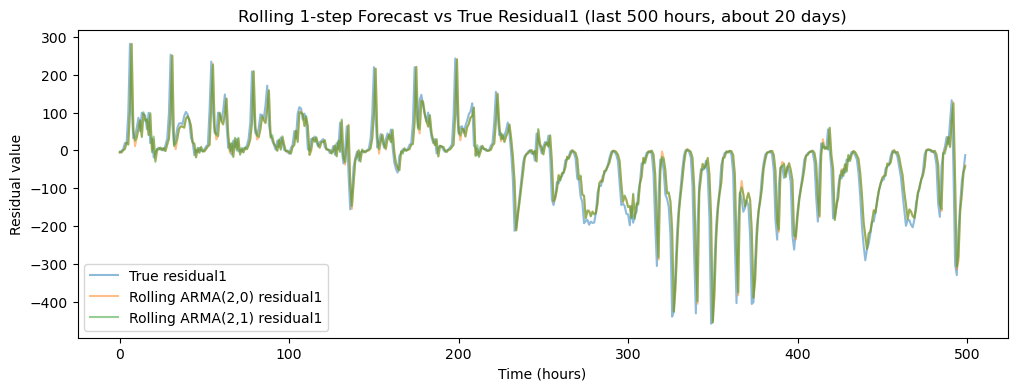

In [25]:
plt.figure(figsize=(12,4))
plt.plot(resid_test.values[-500:], label='True residual1', alpha=0.5)
plt.plot(pred_resid_ar2_roll[-500:], label='Rolling ARMA(2,0) residual1', alpha=0.5)
plt.plot(pred_resid_arma21_roll[-500:], label='Rolling ARMA(2,1) residual1', alpha=0.5)
plt.title("Rolling 1-step Forecast vs True Residual1 (last 500 hours, about 20 days)")
plt.xlabel("Time (hours)")
plt.ylabel("Residual value")
plt.legend()
plt.show()

### Analysis on predicted final bike count

In [26]:
# Reconstruct counts using the same seasonal_mean as before
test['pred_ar2_roll']    = pred_resid_ar2_roll    + test['seasonal_mean'].values
test['pred_arma21_roll'] = pred_resid_arma21_roll + test['seasonal_mean'].values

mae_ar2_c,  rmse_ar2_c  = evaluate(test['cnt'], test['pred_ar2_roll'])
mae_a21_c,  rmse_a21_c  = evaluate(test['cnt'], test['pred_arma21_roll'])

print("ROLLING AR(2) reconstructed     - MAE:", mae_ar2_c,  "RMSE:", rmse_ar2_c)
print("ROLLING ARMA(2,1) reconstructed - MAE:", mae_a21_c, "RMSE:", rmse_a21_c)

ROLLING AR(2) reconstructed     - MAE: 42.053318014404084 RMSE: 65.4162113953737
ROLLING ARMA(2,1) reconstructed - MAE: 41.882434988136346 RMSE: 64.95978205131472


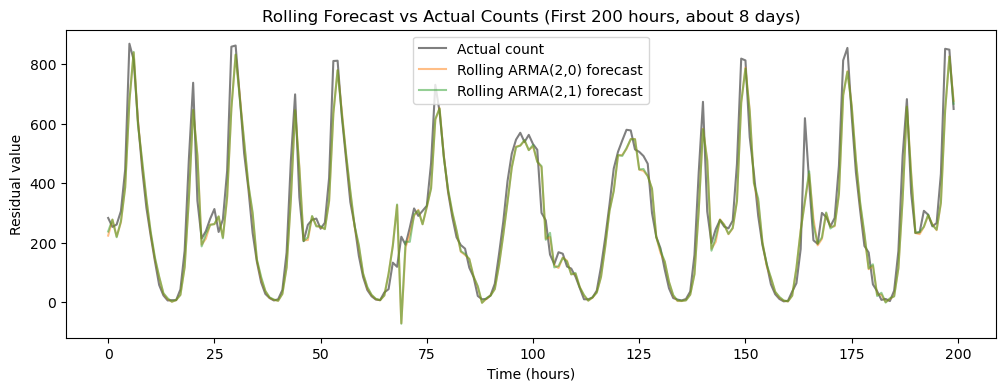

In [27]:
plt.figure(figsize=(12,4))
plt.plot(test['cnt'].values[:200], label='Actual count', alpha=0.5, color = PlotColors.true)
plt.plot(test['pred_ar2_roll'].values[:200], label='Rolling ARMA(2,0) forecast', alpha=0.5, color = PlotColors.ar2)
plt.plot(test['pred_arma21_roll'].values[:200], label='Rolling ARMA(2,1) forecast', alpha=0.5, color = PlotColors.arma21)
plt.title("Rolling Forecast vs Actual Counts (First 200 hours, about 8 days)")
plt.xlabel("Time (hours)")
plt.ylabel("Residual value")
plt.legend()
plt.show()

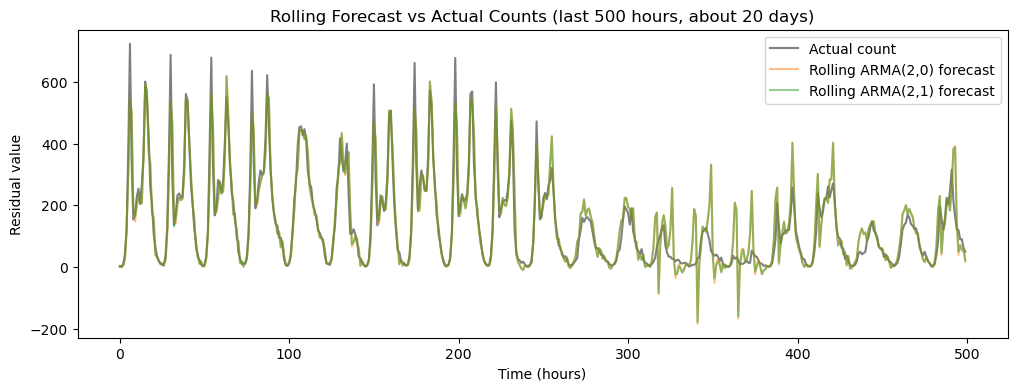

In [28]:
plt.figure(figsize=(12,4))
plt.plot(test['cnt'].values[-500:], label='Actual count', alpha=0.5, color = PlotColors.true)
plt.plot(test['pred_ar2_roll'].values[-500:], label='Rolling ARMA(2,0) forecast', alpha=0.5, color = PlotColors.ar2)
plt.plot(test['pred_arma21_roll'].values[-500:], label='Rolling ARMA(2,1) forecast', alpha=0.5, color = PlotColors.arma21)
plt.title("Rolling Forecast vs Actual Counts (last 500 hours, about 20 days)")
plt.xlabel("Time (hours)")
plt.ylabel("Residual value")
plt.legend()
plt.show()

We can observe the both bike count are similar, and they both similarly deviate from the true value in farther timestamp (later in the testset). we observed that prediction of reisudal in three models align for whole testset, but in later timestamp, the reconstructed bike rental count start to devidate. Because we know recnostructed bike count = predicted residual + train seasonal mean. if predicted residual aligns good even in the later time stamp, then the reason of deviation must be the seasonal mean part. then we will verify this using the plot below. The heatmap of seasonal mean difference (test- train) shows that the seaonal mean did changes, the test-set curve is
consistently higher than the training curve across almost all hours. And we can observe that the highest change of about 250 counts up for test set in Thursday 8am and 5 5pm. That means in later period during the test set, the demand of rental bikes largely increased in commute periods. Unfortuantely, the design of ARMA decided that it cannot catch the seasonal mean changes. This is the limitation of ARMA model, cannot adapt changing seasonal mean.

This indicates that bike usage in the future period (the test set) is
systematically higher than in the training period. As a result, the residuals
computed using the training seasonal mean are biased downward on the test
set. When we apply the ARMA model—which is trained on the lower-training
residual distribution—this bias translates into increasing deviation between
the predicted residuals and the true residuals as we move forward in time.

Therefore, part of the forecast drift we observe in rolling predictions is
caused not only by the inherent error accumulation of ARMA recursion but also
by a real shift in the underlying hourly bike demand between the training and
test periods.

This indicates that the increase in demand in the test set is not random noise
but a consistent upward shift concentrated in specific behavioral periods.
Conversely, late-night and early-morning hours show very small differences,
suggesting minimal structural change in off-peak usage. **also, in the bike count rpediciot plot, we can see true boke count oftenly higher than prediction, that further verify our analysis of upward seasonal mean**



### Example: How Seasonality Mismatch Causes Negative Predictions

| Case | Seasonal Mean Used | Predicted Residual | Reconstructed Count | Realistic? | Explanation |
|------|---------------------|--------------------|----------------------|------------|-------------|
| 1 | 500 (train mean) | −100 | 500 − 100 = **400** | ✔ Yes | Residual is small; reconstruction stays positive. |
| 2 | 500 (train mean) | −600 | 500 − 600 = **−100** | ✘ No | ARMA underpredicts residual; adding back the (too small) train mean produces a negative count. |
| 3 | 700 (true test mean) | −600 | 700 − 600 = **100** | ✔ Yes | If the correct test-period seasonality were used, the same residual would reconstruct a valid count. |


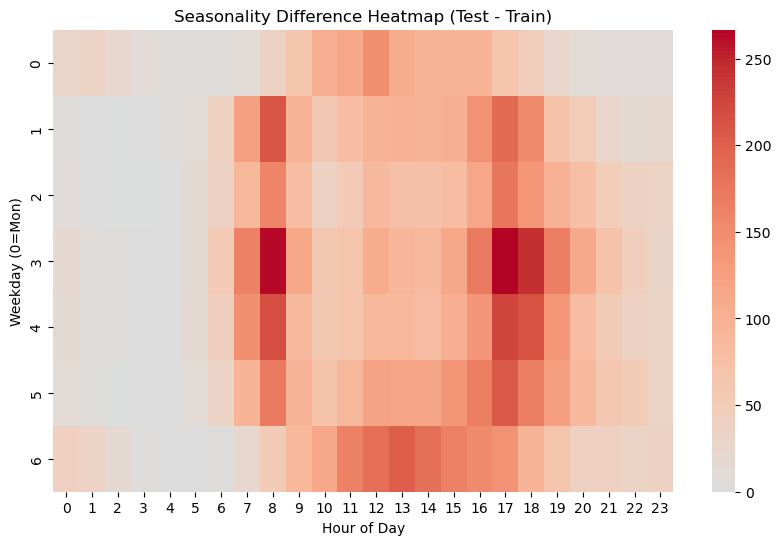

In [29]:
# Compute weekday × hour interactions
season_train = train.groupby(["weekday", "hr"])["cnt"].mean().unstack()
season_test  = test.groupby(["weekday", "hr"])["cnt"].mean().unstack()

season_diff = season_test - season_train

# plt.figure(figsize=(12,5))
# plt.plot(season_train.values.flatten(), alpha=0.7, label="Train weekday×hour mean")
# plt.plot(season_test.values.flatten(), alpha=0.7, label="Test weekday×hour mean")
# plt.title("Weekday × Hour Seasonal Pattern: Train vs Test")
# plt.legend()
# plt.show()

# Heatmap of differences (much more useful)
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(season_diff, cmap="coolwarm", center=0)
plt.title("Seasonality Difference Heatmap (Test - Train)")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday (0=Mon)")
plt.show()


-------

# LDS

In [30]:
from pykalman import KalmanFilter

## model fitting

In [31]:
y_train = train['residual1'].values
y_test  = test['residual1'].values
# Define 1D LDS model (latent dim = 1, obs dim = 1)
kf = KalmanFilter(
    transition_matrices = np.array([[1]]),     # A
    observation_matrices = np.array([[1]]),    # C
)

# Fit parameters using EM on training set
kf = kf.em(y_train, n_iter=50)

# Kalman filtering on training
filtered_state_means, filtered_state_covariances = kf.filter(y_train)


## predict

In [32]:
pred_resid_lds = []

# Start from last filtered state
state_mean = filtered_state_means[-1]
state_cov  = filtered_state_covariances[-1]

A = kf.transition_matrices
C = kf.observation_matrices
Q = kf.transition_covariance
R = kf.observation_covariance

for t in range(len(y_test)):
    # Predict next latent state
    state_mean = A @ state_mean
    state_cov  = A @ state_cov @ A.T + Q
    
    # Predict residual
    y_hat = C @ state_mean
    pred_resid_lds.append(y_hat[0])
    
    # Then update with true test residual
    # (rolling 1-step-ahead Kalman filter)
    state_mean, state_cov = kf.filter_update(
        state_mean,
        state_cov,
        observation = y_test[t]
    )

pred_resid_lds = np.array(pred_resid_lds)

## evalution

In [33]:
mae_lds, rmse_lds = evaluate(y_test, pred_resid_lds)

print("LDS residual MAE:", mae_lds)
print("LDS residual RMSE:", rmse_lds)

LDS residual MAE: 45.92608799551897
LDS residual RMSE: 69.67944235177319


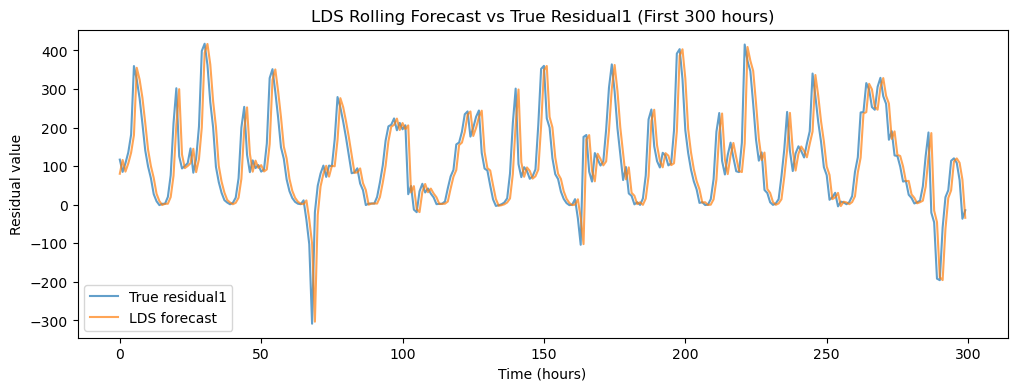

In [34]:
plt.figure(figsize=(12,4))
plt.plot(y_test[:300], label='True residual1', alpha=0.7,)
plt.plot(pred_resid_lds[:300], label='LDS forecast', alpha=0.7)
plt.title("LDS Rolling Forecast vs True Residual1 (First 300 hours)")
plt.xlabel("Time (hours)")
plt.ylabel("Residual value")
plt.legend()
plt.show()

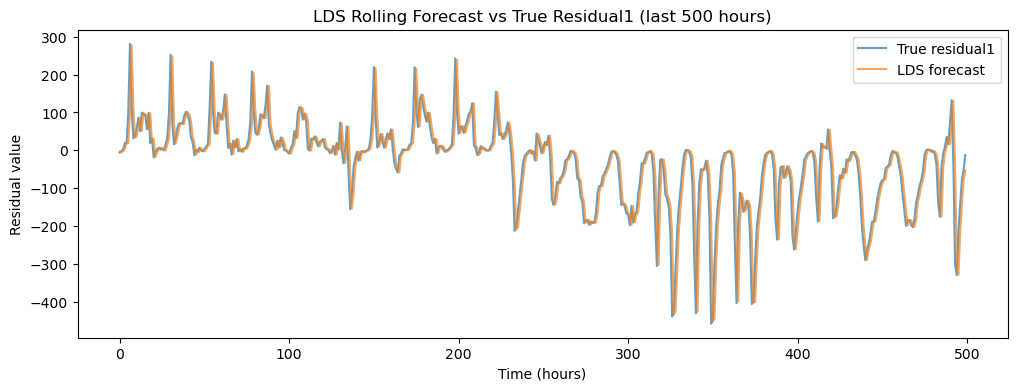

In [35]:
plt.figure(figsize=(12,4))
plt.plot(y_test[-500:], label='True residual1', alpha=0.7)
plt.plot(pred_resid_lds[-500:], label='LDS forecast', alpha=0.7)
plt.title("LDS Rolling Forecast vs True Residual1 (last 500 hours)")
plt.xlabel("Time (hours)")
plt.ylabel("Residual value")
plt.legend()
plt.show()

### bike count prediction

In [36]:
test['pred_lds'] = pred_resid_lds + test['seasonal_mean']
mae_lds_c, rmse_lds_c = evaluate(test['cnt'], test['pred_lds'])

print("LDS reconstructed MAE:", mae_lds_c)
print("LDS reconstructed RMSE:", rmse_lds_c)

LDS reconstructed MAE: 45.92608799551897
LDS reconstructed RMSE: 69.67944235177319


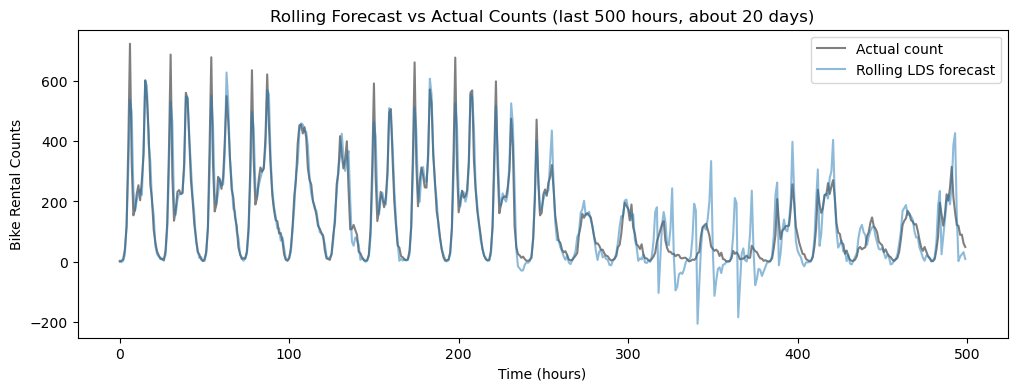

In [37]:
plt.figure(figsize=(12,4))
plt.plot(test['cnt'].values[-500:], label='Actual count', alpha=0.5, color = PlotColors.true)
plt.plot(test['pred_lds'].values[-500:], label='Rolling LDS forecast', alpha=0.5, color = PlotColors.lds)
plt.title("Rolling Forecast vs Actual Counts (last 500 hours, about 20 days)")
plt.xlabel("Time (hours)")
plt.ylabel("Bike Rental Counts")
plt.legend()
plt.show()

# Overall comparison

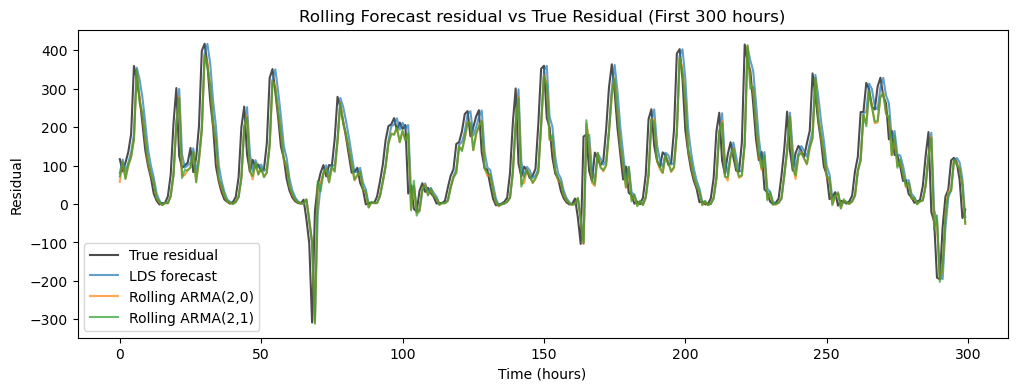

In [43]:
n = 300
plt.figure(figsize=(12,4))
plt.plot(y_test[:300], label='True residual', alpha=0.7, color = PlotColors.true)
plt.plot(pred_resid_lds[:300], label='LDS forecast', alpha=0.7, color = PlotColors.lds)
plt.plot(pred_resid_ar2_roll[:300], label='Rolling ARMA(2,0)', alpha=0.7, color = PlotColors.ar2)
plt.plot(pred_resid_arma21_roll[:300], label='Rolling ARMA(2,1)', alpha=0.7, color = PlotColors.arma21)
plt.title("Rolling Forecast residual vs True Residual (First 300 hours)")
plt.legend()
plt.xlabel("Time (hours)")
plt.ylabel("Residual")
plt.show()

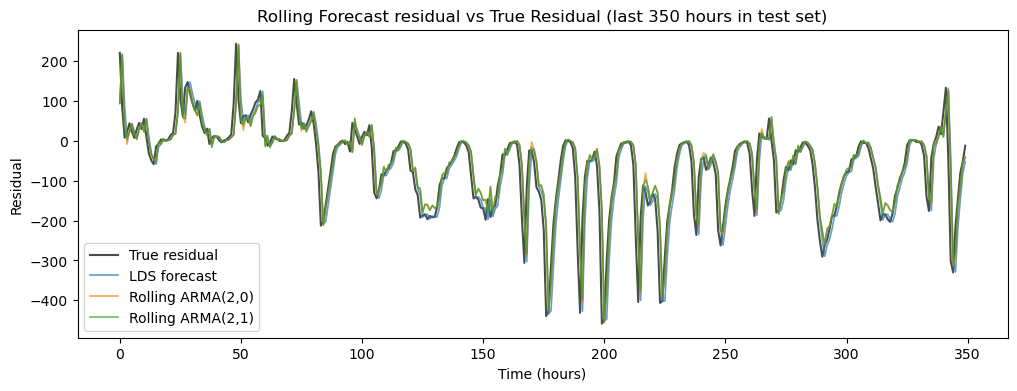

In [ ]:
n = 350
plt.figure(figsize=(12,4))
plt.plot(y_test[-n:], label='True residual', alpha=0.7, color = PlotColors.true)
plt.plot(pred_resid_lds[-n:], label='LDS forecast', alpha=0.7, color = PlotColors.lds, linewidth=1.2)
plt.plot(pred_resid_ar2_roll[-n:], label='Rolling ARMA(2,0)', alpha=0.7, color = PlotColors.ar2, linewidth=1.2)
plt.plot(pred_resid_arma21_roll[-n:], label='Rolling ARMA(2,1)', alpha=0.7, color = PlotColors.arma21, linewidth=1.2)
plt.title(f"Rolling Forecast residual vs True Residual (last {n} hours in test set)")
plt.legend()
plt.xlabel("Time (hours)")
plt.ylabel("Residual")
# plt.savefig(
#     "residual_forecast_last350.png",
#     dpi=300,
#     bbox_inches="tight"
# )
plt.show()

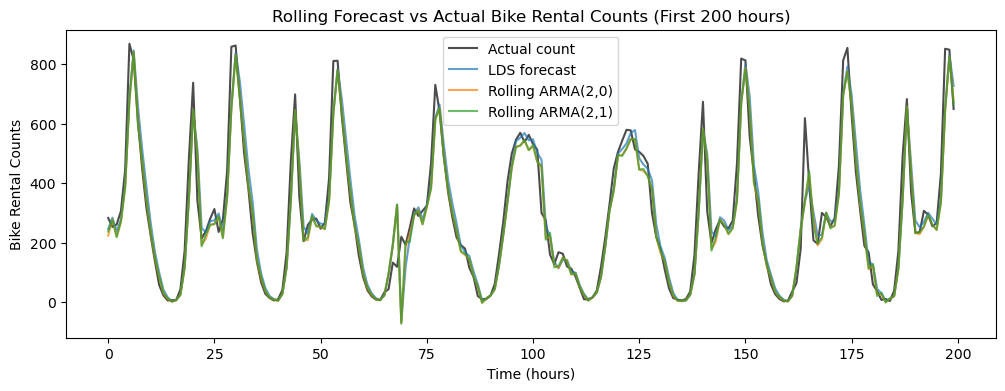

In [45]:
x = np.arange(200)

plt.figure(figsize=(12,4))
plt.plot(x, test['cnt'].values[:200], label='Actual count', alpha=0.7, color = PlotColors.true)
plt.plot(x, test['pred_lds'].values[:200], label='LDS forecast', alpha=0.7, color = PlotColors.lds)
plt.plot(x, test['pred_ar2_roll'].values[:200], label='Rolling ARMA(2,0)', alpha=0.7, color = PlotColors.ar2)
plt.plot(x, test['pred_arma21_roll'].values[:200], label='Rolling ARMA(2,1)', alpha=0.7, color = PlotColors.arma21)

plt.title("Rolling Forecast vs Actual Bike Rental Counts (First 200 hours)")
plt.xlabel("Time (hours)")
plt.ylabel("Bike Rental Counts")
plt.legend()
plt.show()

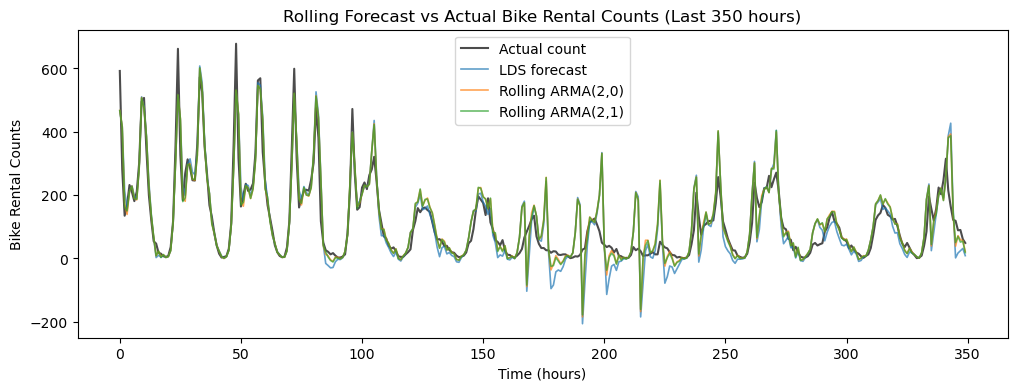

In [ ]:
N = 350
x = np.arange(N)

plt.figure(figsize=(12,4))
plt.plot(x, test['cnt'].values[-N:], label='Actual count', alpha=0.7, color = PlotColors.true)
plt.plot(x, test['pred_lds'].values[-N:], label='LDS forecast', alpha=0.7, color = PlotColors.lds, linewidth=1.2)
plt.plot(x, test['pred_ar2_roll'].values[-N:], label='Rolling ARMA(2,0)', alpha=0.7, color = PlotColors.ar2, linewidth=1.2)
plt.plot(x, test['pred_arma21_roll'].values[-N:], label='Rolling ARMA(2,1)', alpha=0.7, color = PlotColors.arma21, linewidth=1.2)

plt.title("Rolling Forecast vs Actual Bike Rental Counts (Last 350 hours)")
plt.xlabel("Time (hours)")
plt.ylabel("Bike Rental Counts")
plt.legend()
# plt.savefig(
#     "bike_rental_count_forecast_last350.png",
#     dpi=300,
#     bbox_inches="tight"
# )

plt.show()


- ROLLING AR(2) reconstructed 
    - MAE: 42.053 RMSE: 65.416
- ROLLING ARMA(2,1) reconstructed 
    - MAE: 41.882 RMSE: 64.960 
- LDS residual 
    - MAE: 45.926 RMSE: 69.679

Even though LDS aligns better to true value, but its RMSE and MAE are instead larger! Reason:
- LDS = smoother, denoised, adaptive tracking
- ARMA = more reactive to noise, but lower pointwise error
- The Kalman filter is fundamentally a smoother / denoiser. It intentionally pull prediction toward its current latent state, which update for each new datapoint. That helps LDS to avoid over drift to noise, and LDS need multiple "noise" point to notice that those "noise" are signal of trend change, then it adapt. And those noise are often peaks or drops, then the wrose predictions in those case caused larger RMSE/MAE and over the advantages of normal stable trends.
- But ARMA follow the sudden more closely becuase its mechanism is to use datapoints of the last few timestamp to make next prediction. Any sudden change of those datapoints used will have directly impact to the prediction. 
- That also implys that bike count are unstable, even though we remove the seasonality. (one potential reason of weather will be discussed below)